In [3]:
# pytocrh와 기타 util라이브러리를 import해온다.
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor

# 텐서의 차원관리를 해주는, einops 
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

# pytorch모델의 구조도와 요약을 확인할 수 있다.
from torchsummary import summary

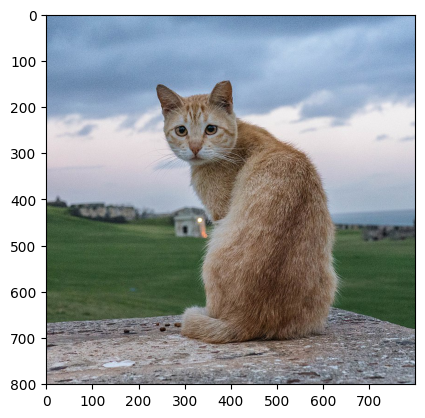

In [4]:
img = Image.open('./image.jpg')

fig = plt.figure()
plt.imshow(img)

In [5]:
transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0)
x.shape

torch.Size([1, 3, 224, 224])

In [6]:
patch_size = 16
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
# [1, 3, 224, 224]-> [1, (224//16)**2, 16*16*3]
# 가운데 부분은 sequence의 length가 될 것임 그리고 맨 오른쪽 부분은 Dimension이 될 것임
patches.shape # [1, 196, 768]

torch.Size([1, 196, 768])

### Patch Embeddings

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # ViT논문에서는 Conv2d를 사용하는게, Linear레이어 하나를 더 추가하는 것보다 더 계산 효율적이라고 했음
            # 최종적으로 [batch_size, (h//patch_size)*(w//patch_size), embed_size)]크기의 텐서가 된다.
             nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
             Rearrange('b e (h) (w) -> b (h w) e')
            #  Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            #  nn.Linear(patch_size * patch_size * in_channels, emb_size) # linear projection
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

### CLS Token

여기서는 cls token을 추가하고, position embedding을 더해주어야 한다.

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # ViT논문에서는 Conv2d를 사용하는게, Linear레이어 하나를 더 추가하는 것보다 더 계산 효율적이라고 했음
            # 최종적으로 [batch_size, (h//patch_size)*(w//patch_size), embed_size)]크기의 텐서가 된다.
             nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
             Rearrange('b e (h) (w) -> b (h w) e')
            #  Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            #  nn.Linear(patch_size * patch_size * in_channels, emb_size) # linear projection
        )

        # nn.parameter는 모델에 학습 가능한 파라미터를 추가할 때 텐서로 추가하는 방법이다.
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_token = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_token, x], dim=1)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

### Position Embedding

우리는 여태까지 patch의 spatial information을 신경을 안썼는데, Position Embedding을 진행해보자.
ViT에서는 해당 정보를 모델이 학습한다. 하지만 Transformer(2017)년 논문에서는 fixed된 함수를 사용하기도 한다.
ViT에서 해당 텐서의 크기는 <code>N_PATCHES + 1, EMBED_SIZE</code> 이다.

In [9]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # ViT논문에서는 Conv2d를 사용하는게, Linear레이어 하나를 더 추가하는 것보다 더 계산 효율적이라고 했음
            # 최종적으로 [batch_size, (h//patch_size)*(w//patch_size), embed_size)]크기의 텐서가 된다.
             nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
             Rearrange('b e (h) (w) -> b (h w) e')
            #  Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            #  nn.Linear(patch_size * patch_size * in_channels, emb_size) # linear projection
        )

        # nn.parameter는 모델에 학습 가능한 파라미터를 추가할 때 텐서로 추가하는 방법이다.
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_token = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_token, x], dim=1)
        x += self.positions
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

### Transformer

트랜스포머(Encoder)는 query, key, values를 입력으로 받는다. 
우리의 경우는 multi-head attention을 사용하는데, 이는 n_heads만큼 input을 쪼개고 encoder에 투입하는 것이다.

In [10]:
'''
    원래 트랜스포머에서 Wq, Wk, Wv 벡터의 차원은 d_model보다 작은 차원을 갖는다.
    [emb_size, d_model // num_heads]의 차원을 가지고 추후에 MSA의 끝단에서 concatenate하게 된다.
'''
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        self.scaling = (self.emb_size // num_heads) ** -0.5

    def forward(self, x: Tensor, mask: Tensor = None) -> Tensor:
        # 위에서 말했던 것처럼 num_heads로 keys, queries, values를 쪼갠다.
        # [batch, heads, seq_len, emb_size] 크기의 텐서가 된다.
        # [1, 8, 197, 96] -> x는 나누기 전인 [1, 197, 768]
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)

        # print('qureis shape -> ', queries.shape)
        # print('keys shape -> ', keys.shape)
        # print('values shape -> ', values.shape)

        # queries, keys를 이제 행렬곱 해주어야 한다.
        # 아래 코드와같이 하면 자동으로 transpose되고 내적이 된다. 
        # [batch, heads, query_len, key_len] 크기의 텐서가 된다.
        # [1, 8, 197, 197]
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys)
        # print('energy shape -> ', energy.shape)

        if mask is not None:
            fill_value = torch.finfo(torch.float32).min # -max
            energy.mask_fill(~mask, fill_value)

        att = F.softmax(energy, dim=-1) * self.scaling  # scaling된 attention score
        att = self.att_drop(att)
        # print('att shape -> ', att.shape)

        out = torch.einsum('bhal, bhlv -> bhav', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out


patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

### Residuals

transformer block은 residual connection또한 가지고 있다.

In [11]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [12]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            # upsample을 expansion ratio만큼 해주었음 원래 트랜스 포머에서도 d_model=512 -> dfff=2048 (expansion ratio = 4)
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            # Dropout은 원래 과적합이 일어나기 쉬운 Dense, Fully Connected Layer뒤에 적용하는 것이 일반적이다.
            # Attention Layer뒤에도 Dropout을 사용하는데, 이는 모델이 특정 헤드에 지나치게 의존하는 것을 방지한다. -> 위에 적용했음
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size)
        )

In [13]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                emb_size: int = 768,
                drop_p: float = 0,
                forward_expansion: int = 4,
                forward_drop_p: float = 0.,
                **kwargs):
                super().__init__(
                    ResidualAdd(
                        nn.Sequential(
                            nn.LayerNorm(emb_size),
                            MultiHeadAttention(emb_size, **kwargs),
                            nn.Dropout(drop_p))),
                    ResidualAdd(
                        nn.Sequential(
                            nn.LayerNorm(emb_size), # layer normalization
                            FeedForwardBlock(
                                emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                            nn.Dropout(drop_p)))
                )


patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape
    

torch.Size([1, 197, 768])

In [14]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])

### Head
마지막은, normal한 Fully connected layer이다. 이는 최종적으로 class probability를 출력하게 된다.

In [15]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes)
        )

In [16]:
class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 1000,
                **kwargs):
                super().__init__(
                    PatchEmbedding(in_channels, patch_size, emb_size, img_size),
                    TransformerEncoder(depth, emb_size=emb_size, **kwargs),
                    ClassificationHead(emb_size, n_classes)
                )


In [17]:
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
MultiHeadAttention-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
      ResidualAdd-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 1

### Train
model params는 큰 dataset에서만 정확도가 높은 단점을 보완하기 위한 
Vision Transformer for Small-Size Datasets (https://arxiv.org/pdf/2112.13492.pdf) 을 따릅니다.

- epoch: 50
- batch_size: 128
- init learning rate: 0.001
- optimizer: Adam(weight_decay: 5e-5)
- model: Vit(img_size=32, patch_size=4, in_channels=3, num_classes=10, emb_size=192, depth=12,
            num_heads=12, expansion=2)
- loss: cross entropy (classification)
- dataset: cifar10 (torchvision.data)
- data augmentation: random crop, horizontal random flip

In [18]:
import os
import time
from tqdm import tqdm
import argparse
import torchvision.transforms as tfs
from torch.utils.data import DataLoader
from timm.models.layers import trunc_normal_
from torchvision.datasets.cifar import CIFAR10
from torch.utils.tensorboard import SummaryWriter

In [19]:
class ArgumentParser():
    def __init__(self, epoch: int = 50, batch_size: int = 128, lr: float = 1e-3, step_size: int = 100,
                    root: str = './CIFAR10', log_dir: str = './log', name: str = 'vit_cifar10',
                    rank: int = 0):
        self.epoch = epoch
        self.batch_size = batch_size
        self.lr = lr
        self.step_size = step_size
        self.root = root
        self.log_dir = log_dir
        self.name = name
        self.rank = rank
        return

In [20]:

vit_cifar_input: dict = {
    "img_size": 32,
    "patch_size": 4,
    "n_classes": 10,
    "emb_size": 192,
    "forward_expansion": 2
}

ops = ArgumentParser()
# device 셋팅
device = torch.device('cuda:{}'.format(0) if torch.cuda.is_available() else 'cpu')

# dataset / dataloader 정의를 해준다.
transform_cifar = tfs.Compose([
    tfs.RandomCrop(32, padding=4),
    tfs.RandomHorizontalFlip(),
    tfs.ToTensor(),
    tfs.Normalize(mean=(0.4914, 0.4822, 0.4465),
                std=(0.2023, 0.1994, 0.2010)) 
])

train_set = CIFAR10(root=ops.root,
                    train=True,
                    download=True,
                    transform=transform_cifar)

test_set = CIFAR10(root=ops.root,
                    train=False,
                    download=True,
                    transform=transform_cifar)

train_loader = DataLoader(dataset=train_set,
                        shuffle=True,
                        batch_size=ops.batch_size)

test_loader = DataLoader(dataset=test_set,
                        shuffle=True,
                        batch_size=ops.batch_size)
                    
# model 정의
model = ViT(**vit_cifar_input).to(device)

# criterion 정의
criterion = nn.CrossEntropyLoss()

# optimizer 정의
optimizer = torch.optim.Adam(model.parameters(),
                            lr=ops.lr,
                            weight_decay=5e-5)

# scheduler 정의
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=ops.epoch, eta_min=1e-5)

# logger 정의
os.makedirs(ops.log_dir, exist_ok=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# training
writer = SummaryWriter()

print("training....")

best_accuracy = 0.0

for epoch in range(ops.epoch):
    model.train()
    tic = time.time()
    
    for idx, (img, target) in enumerate(tqdm(train_loader)):
        img = img.to(device) # [N, 3, 32, 32] <- cifar with batch size
        target = target.to(device) # [N]
        output = model(img) # classification_head의 출력이니까 [N, 10] -> cifar10이니까 class=10
        loss = criterion(output, target) # crossentropy 값 계산 -> 단순히 분류 문제이기 때문
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for param_group in optimizer.param_groups:
            lr = param_group['lr']

        
        if idx % ops.step_size == 0:
            
            writer.add_scalar('Training loss', loss, epoch * len(train_loader) + idx)

            print('Epoch : {}\t'
                    'step : [{}/{}]\t'
                    'loss : {}\t'
                    'lr   : {}\t'
                    'time   {}\t'
                    .format(epoch,
                            idx, len(train_loader),
                            loss,
                            lr,
                            time.time() - tic))

        save_path = os.path.join(ops.log_dir, ops.name, 'saves')
        os.makedirs(save_path, exist_ok=True)


    # test
    print('Validation of epoch[{}]'.format(epoch))
    model.eval()
    correct = 0
    val_avg_loss = 0
    total = 0
    
    with torch.no_grad():
        for idx, (img, target) in enumerate(tqdm(test_loader)):
            img = img.to(device)
            target = target.to(device)
            output = model(img)
            loss = criterion(output, target)

            output = torch.softmax(output, dim=1)
            pred, idx_ = output.max(-1)
            correct += torch.eq(target, idx_).sum().item()
            total += target.size(0)
            val_avg_loss += loss.item()

    print('Epoch {} test : '.format(epoch))
    accuracy = correct / total
    print("accuracy : {:.4f}%".format(accuracy * 100.))

    val_avg_loss = val_avg_loss / len(test_loader)

    if epoch % 5 == 0 and accuracy > best_accuracy:
        best_accuracy = accuracy
        
        save_path = os.path.join(ops.log_dir, ops.name, 'saves')
        os.makedirs(save_path, exist_ok=True)
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_accuracy': best_accuracy
        }

        torch.save(checkpoint, os.path.join(save_path, ops.name + '.{}.pth.tar'.format(epoch)))

    writer.add_scalar('Test loss', loss, epoch)
    writer.add_scalar('Tert accuracy', val_avg_loss, epoch)
    
    scheduler.step()

### 학습한 모델 사용해보기

In [65]:
import matplotlib.pyplot as plt

def display_image_with_label(img, label):
    plt.imshow(img )
    plt.axis('off')  # 축 제거

    # 레이블(클래스 이름) 표시
    plt.title(f"Predicted label: {label}")

    # 이미지와 레이블 함께 출력
    plt.show()

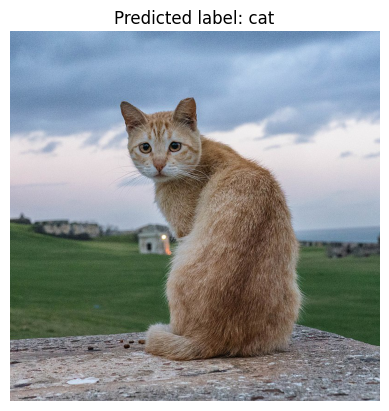

In [66]:


model = ViT(**vit_cifar_input)

checkpoint_path = './log/vit_cifar10/saves/vit_cifar10.48.pth.tar'
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])

cifar10_transform = Compose([Resize((32, 32)), ToTensor()])


origin_img = Image.open('./image.jpg')  # 분류하고자 하는 이미지 파일
img = cifar10_transform(origin_img)
img = img.unsqueeze(0)  # 배치 차원 추가


with torch.no_grad():  # 그래디언트 계산 비활성화
    model.eval()
    outputs = model(img)
    _, predicted = torch.max(outputs, 1)

classes = [
    "airplane",  # 비행기
    "automobile",  # 자동차
    "bird",  # 새
    "cat",  # 고양이
    "deer",  # 사슴
    "dog",  # 개
    "frog",  # 개구리
    "horse",  # 말
    "ship",  # 배
    "truck"  # 트럭
]

display_image_with_label(origin_img, classes[predicted[0]])